In [21]:
import numpy as truenp

import matplotlib.pyplot as plt
import matplotlib.cm as color
better_magma = color.magma
better_magma.set_bad('black',1.)
import matplotlib.colors as c

from prysm import (
    mathops, 
    conf,
)
from prysm.mathops import (
    np,
    fft,
    interpolate,
    ndimage,
)
from prysm.coordinates import (
    make_xy_grid, 
    cart_to_polar,
)
from prysm.propagation import Wavefront as WF
from prysm.propagation import (
    focus_fixed_sampling,
    focus_fixed_sampling_backprop
)                              
from prysm.thinlens import (
    defocus_to_image_displacement,
    image_displacement_to_defocus,
)
from prysm.geometry import (
    circle,
    spider,
)
from prysm.polynomials import (
    lstsq,
    noll_to_nm,
    zernike_nm,
    zernike_nm_seq,
    hopkins,
    sum_of_2d_modes,
    sum_of_2d_modes_backprop
)
mathops.set_backend_to_cupy()

from utils import generate_freqs, kneePSD, generate_time_series, ensure_np

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
data = {'f_max' : 1,         # hz
        't_max' : 10 * 3600, # sec
        'f_knee' : 1 / (2 * 3600), # hz
        'slope' : 5,
        'freqs' : [],
        'psd' : [],
        'times' : [],
        'DOF' : {'M1_dx' : {'RMS' : 25e-6, 'timeseries' : []},
                 'M1_dy' : {'RMS' : 25e-6, 'timeseries' : []},
                 'M1_dz' : {'RMS' : 25e-6, 'timeseries' : []},
                 'M1_tx' : {'RMS' : 5e-6, 'timeseries' : []},
                 'M1_ty' : {'RMS' : 5e-6, 'timeseries' : []},
                 'M2_dx' : {'RMS' : 25e-6, 'timeseries' : []},
                 'M2_dy' : {'RMS' : 25e-6, 'timeseries' : []},
                 'M2_dz' : {'RMS' : 25e-6, 'timeseries' : []},
                 'M2_tx' : {'RMS' : 25e-6, 'timeseries' : []},
                 'M2_ty' : {'RMS' : 25e-6, 'timeseries' : []},}}

In [30]:
f_max = data['f_max']
t_max = data['t_max']
f_knee = data['f_knee']
slope = data['slope']

freqs, times = generate_freqs(Nf=2**18+1, f_max=f_max)
psd = kneePSD(freqs, 1, f_knee, slope)

for i, key in enumerate(data['DOF']):
    rms = data['DOF'][key]['RMS']
    timeseries = generate_time_series(psd, f_max, rms=rms, seed=727 + i)

    timeseries -= timeseries[0]
    timeseries = timeseries[times < t_max]
    timeseries *= rms / np.sqrt(np.mean(timeseries ** 2))

    data['DOF'][key]['timeseries'] = ensure_np(timeseries)

times = times[times < t_max]

data['times'] = ensure_np(times)
data['freqs'] = ensure_np(freqs)
data['psd'] = ensure_np(psd)

interval = float(times[1] - times[0])
print(interval)

0.5


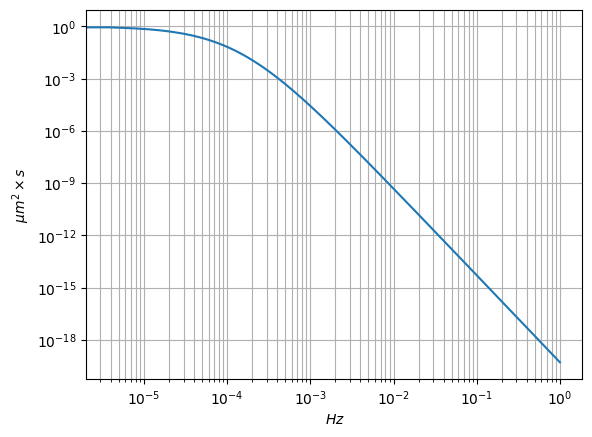

In [41]:
plt.loglog(data['freqs'], data['psd'])
plt.ylabel(r'$\mu m^2 \times s$')
plt.xlabel(r'$Hz$')
plt.grid(which='both')

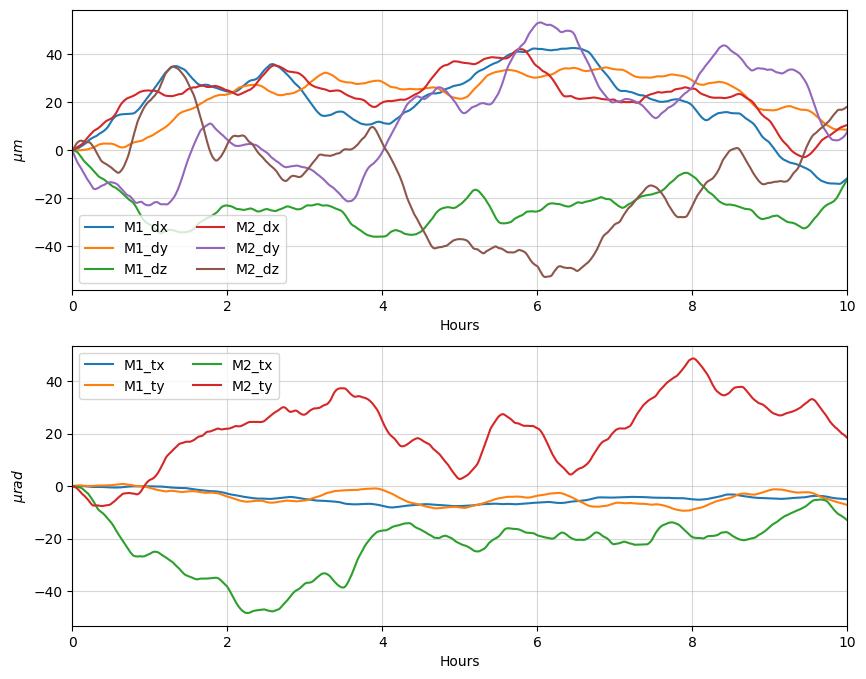

In [44]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
for key in data['DOF']:
    if 'd' in key:
        plt.plot(data['times'] / 3600, data['DOF'][key]['timeseries'] * 1e6, label=key)
plt.legend(ncols=2)
plt.xlabel('Hours')
plt.ylabel(r'$\mu m$')
plt.xlim([0, 10])
plt.grid(alpha=0.5)

plt.subplot(212)
for key in data['DOF']:
    if 't' in key:
        plt.plot(data['times'] / 3600, data['DOF'][key]['timeseries'] * 1e6, label=key)
plt.legend(ncols=2)
plt.xlabel('Hours')
plt.ylabel(r'$\mu rad$')
plt.xlim([0, 10])
plt.grid(alpha=0.5)